## Facebook Prophet

Prophet is a package from Facebook that contains a suite of tools for analysing and modelling time series data, including:

    - Ability to recognise daily, weekly, monthly and annual data
    - Create models using time series data
    - Explore components of model (trend, seasonality etc)
    - Perform forecasting and cross validation
    - Add regressors (additional features) to model to improve predictive power
    
It is by no means perfect and has its critics, however I believe it is a good starting point for anyone who is new to working with time series data looking to make predictions.

In [1]:
import pandas as pd
import numpy as np
import warnings
from prophet import Prophet
from prophet.plot import plot_yearly
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric, plot
from sklearn.preprocessing import MinMaxScaler

from source import (start_pipeline, create_lockdown_predictors, create_date_predictors, 
create_holiday_predictors, create_weather_predictors, drop_na, min_max_scaler)

In [2]:
#import merged footfall data
footfalldf = pd.read_csv("./data/inputs/LCC_footfall_cleaned_2021.csv",
								  parse_dates=['Date','DateTime'],
								  dtype={"BRCYear": int,"BRCWeekNum":int})

#Import regressor files
new_weather = pd.read_csv("./data/inputs/weatherdata.csv",parse_dates=['timestamp'],index_col='timestamp')
previous_weather = pd.read_csv("./data/inputs/overall_weather.csv",parse_dates=['date'],index_col='date',dayfirst=True)
bankhols = pd.read_csv('./data/inputs/ukbankholidays.csv',parse_dates=['ukbankhols'])
schoolterms = pd.read_csv('./data/inputs/schoolterms.csv',parse_dates=['date'],
                          dayfirst=True,index_col='date',usecols=['schoolStatus','date'])



In [3]:
#Resample into daily footfall.
day = footfalldf.groupby( [pd.Grouper(key='DateTime',freq='D')])['Count'].aggregate(np.mean).to_frame()
#dayfinal = pd.concat([day,frame],verify_integrity=True)
day = day.drop(day[day['Count'] == 0].index)
day = day.rename(columns={'Count' : 'mean_hourly_footfall'})
#Set frequency to daily
day = day.asfreq('D').dropna()

The following chart shows mean hourly footfall for all cameras used in this analysis between 1st January 2015 and April 2021.

There is evidence of seasonality, although it is difficult to spot at such a granular level.  The large drop off due to COVID-19 restrictions can be seen towards the end.

You can also see some of the inherent problems with time series data.  Missing values are instantly clear and can impact modelling later on if not dealt with.  Luckily they have already been cleaned out of this dataset but haven't been masked out of the chart for demonstration purposes.

#### Mean hourly footfall for all cameras in Leeds City Centre between 1st January 2015 and 25th April 2021

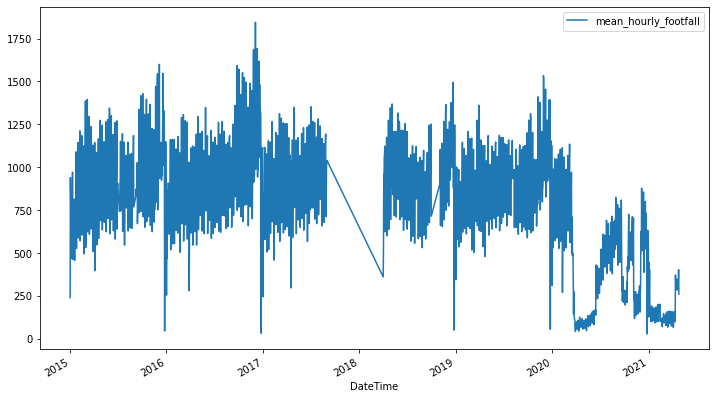

In [4]:
day_for_plot = day.loc[day.index >= '2015-01-01']
dayplot = day_for_plot.plot(figsize=(12,7))

Prophet can be used to analyse and make predictions on time series data, taking into account the relationships inherent in this type of data and other elements such as seasonality.

In [5]:
#Prepare expected column names
processed_data = day.reset_index()
processed_data.columns = ['ds','y']

#Create a prelockdown dataset for use in the initial model
prelockdown = processed_data.loc[(processed_data.ds < '2020-03-16') & (processed_data.ds >= '2015-01-01')]

lockdown = processed_data.loc[processed_data.ds >= '2020-03-16'].drop(['y'],axis=1)

The chart below shows a simple forecast made using training data from between 1st January 2015 and 16th March 2020 (a designated start of COVID-19 lockdowns in the UK).

Whilst the granularity makes interpreting the forecast difficult, what it does show is how the model fits to the training data and uses that to make a prediction on data for the rest of 2020 and start of 2021.  This is making forecasts on a very simple and linear scale, without adjusting any hyperparameters, conducting validation or adding regressors to the model.

#### Simple forecast made using training data from between 1st January 2015 and 16th March 2020

22:34:55 - cmdstanpy - INFO - Chain [1] start processing
22:34:55 - cmdstanpy - INFO - Chain [1] done processing


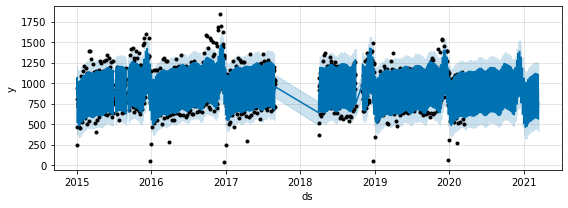

In [6]:
#Define Prophet model
model = Prophet()

#Fit the model
model.fit(prelockdown)

#future is just a dataset that can be used to predict on.  It can be out of sample or represent an in sample test dataset.
future = model.make_future_dataframe(periods=365)

#use the model to make a forecast
forecast = model.predict(future)

#plot the model
plot = model.plot(forecast, figsize=(8,3))

### Seasonality

A useful feature of Prophet is to detect the seasonality of a dataset and plot the results, as shown below.  The vague idea that there was some in the previous plots is now much clearer, we can see that generally footfall rises throughout the year, with a large peak in December (most likely due to Christmas).

As Prophet is aware of this seasonality, it will take it into account when making a prediction and not allow the model to be skewed by outliers that appear regularly.

#### Annual seasonality of previous model

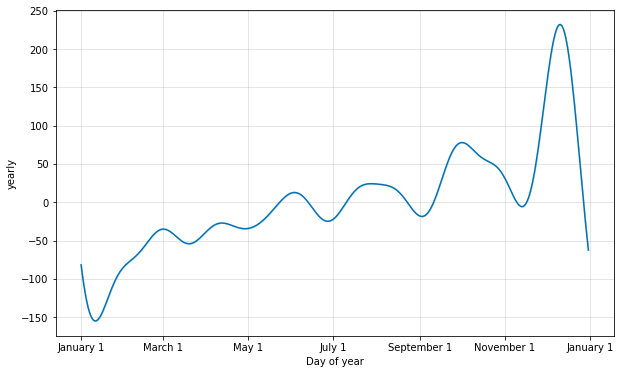

In [7]:
yearly_seasonality = plot_yearly(model)

### Validation

Most machine learning models need robust validation before they are used to make predictions.

A simple way to do this with time series data is to take a train/validation split and then use historical data to predict 'in-sample' on later historical data, comparing the predictions with the true recorded values later.

The chart below plots the results of a forecast made on data from 1st January 2019 to 15th March 2020, using training data from prior to this period.  To make comparisons between the two clearer and produce a less cluttered graph, a 7-day rolling average of the true and predicted values was used.

In [8]:
#Evaluation of model.  Training dataset set as everything prior to 1st January 2019, 
#test as everything after but prior to the start of lockdown

train = prelockdown.loc[prelockdown.ds <'2019-01-01']
test = prelockdown.loc[prelockdown.ds >='2019-01-01'].drop(['y'],axis=1)

In [9]:
#Define Prophet model
model = Prophet()

#Fit the model
model.fit(train)

#use the model to make a forecast
forecast = model.predict(test)

#calculate MAE between expected and predicted values
test_y = prelockdown.loc[prelockdown.ds >='2019-01-01']
y_true = test_y['y'].values
y_pred = forecast['yhat'].values
mae = mean_absolute_error(y_true,y_pred)

plotdf = pd.DataFrame({'Date': test_y['ds'], 'y_true':y_true,'y_pred':y_pred})
plotdf.set_index(['Date'],inplace=True)

22:34:57 - cmdstanpy - INFO - Chain [1] start processing
22:34:57 - cmdstanpy - INFO - Chain [1] done processing


#### Chart showing 7 day average of predicted vs true mean hourly footfall


MAE: 127.482


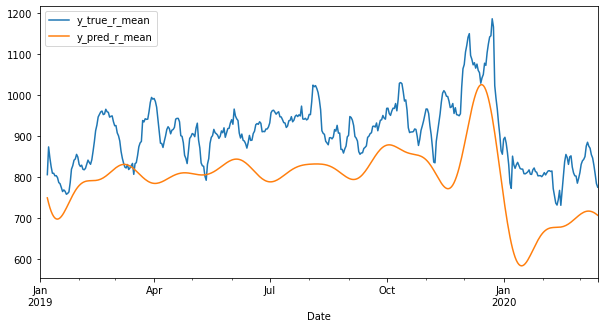

In [10]:
plotdf['y_true_r_mean'] = plotdf['y_true'].rolling(7).mean()
plotdf['y_pred_r_mean'] = plotdf['y_pred'].rolling(7).mean()

plotdf.drop(['y_pred','y_true'],axis=1, inplace=True)

fig = plotdf.plot(figsize=(10,5))
print('MAE: %.3f' % mae)

Generally it looks like the model doesn't do too bad a job.  A Mean Average Error of 17635.286 doesn't really say much, however the prediction picks up the trend of the data fairly well, even if it does miss a lot of the nuance and detail of the true values.

### Regressors

Another powerful feature of Prophet is to allow you to add external variables (regressors) to the model.  This requires some domain experience to understand what factors might have an impact on your outcome variable, an important skill for a Data Scientist.

The idea is that alongside the inherent relationship between the records due to it being time series, the regessor variables will add extra predictive power to the model.  This is useful generally for most models, as it helps the algorithm learn more about why the outcome variable changes and gives it more information to work with in the test set.  Was it a particularly warm day or was it raining heavily?  Those days might appear as outliers when compared to typical ones.  Was it a bank holiday?  Were the schools open or closed?

This can also be used to help predict footfall for large events such as COVID-19, where many different external factors combined to reduce pedestrian traffic significantly.

#### Adding regressors to a Prophet Model


In [11]:
#Run a pipeline to clean and process the resampled data, adding regressors and dropping null values
# Functions can be found in source.py, most are just combining various datasets and joining them onto the footfall.
warnings.filterwarnings('ignore')
processed_data_with_regressors = (day
                          .pipe(start_pipeline)
                          .pipe(create_date_predictors)
                          .pipe(create_holiday_predictors,bankhols,schoolterms)
                          .pipe(create_weather_predictors, new_weather, previous_weather)
                          .pipe(drop_na))

# Selecting the regressors we're interested in (See above)
processed_data_with_regressors = processed_data_with_regressors.loc[:,[
    'mean_hourly_footfall',
    'wday_Saturday',
    'wday_Sunday',
    'mean_temp',
    'wind_speed',
    'rain',
    'bank_hols',
    'schoolholidays']]


regressors = processed_data_with_regressors.columns
regressors = regressors.tolist()
regressors.remove('mean_hourly_footfall')

#Prepare expected column names
processed_data_with_regressors = processed_data_with_regressors.reset_index()
processed_data_with_regressors = processed_data_with_regressors.rename(columns={'key_0':'ds','mean_hourly_footfall':'y'})

prelockdown = processed_data_with_regressors.loc[
    (processed_data_with_regressors.ds < '2020-03-16') & (processed_data_with_regressors.ds >= '2015-01-01')]

lockdown = processed_data_with_regressors.loc[processed_data_with_regressors.ds >= '2020-03-16'].drop(['y'],axis=1)

cols_to_scale = ['mean_temp', 'wind_speed', 'rain']

#Evaluation of model
train = prelockdown.loc[prelockdown.ds <'2019-01-01']
test = prelockdown.loc[prelockdown.ds >='2019-01-01'].drop(['y'],axis=1)

train.loc[:,cols_to_scale] = min_max_scaler.fit_transform(train.loc[:,cols_to_scale])

In [12]:
#Define Prophet model
model = Prophet()
for r in regressors:
	model.add_regressor(r)
#Fit the model
model.fit(train)

22:34:59 - cmdstanpy - INFO - Chain [1] start processing
22:34:59 - cmdstanpy - INFO - Chain [1] done processing


In [13]:
test.loc[:,cols_to_scale] = min_max_scaler.transform(test.loc[:,cols_to_scale])
#use the model to make a forecast
forecast = model.predict(test)

#calculate MAE between expected and predicted values
future_y = prelockdown.loc[prelockdown.ds >='2019-01-01']
y_true = future_y['y'].values
y_pred = forecast['yhat'].values
mae = mean_absolute_error(y_true,y_pred)

plotdf = pd.DataFrame({'Date': future_y['ds'], 'y_true':y_true,'y_pred':y_pred})
plotdf.set_index(['Date'],inplace=True)

The chart below shows the same process outlined earlier, but with the following regressors added to the model:
<ul>
<li>Saturday or not?</li>
<li>Sunday or not?</li>
<li>Mean daily temperature (degree celsius)</li>
<li>Mean daily wind speed (MPH)</li>
<li>Total daily rainfall (mm)</li>
<li>Bank Holiday or not?</li>
<li>School Holiday or not?</li>
</ul>

#### Chart showing 7 day average of predicted vs true mean hourly footfall (with regressors)


Mean Average Error: 76.178


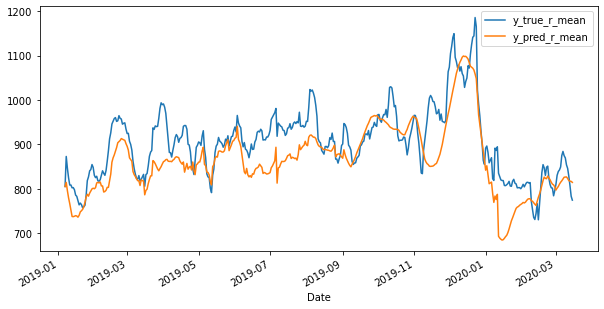

In [14]:
plotdf['y_true_r_mean'] = plotdf['y_true'].rolling(7).mean()
plotdf['y_pred_r_mean'] = plotdf['y_pred'].rolling(7).mean()

plotdf.drop(['y_pred','y_true'],axis=1, inplace=True)


fig = plotdf.plot(figsize=(10,5))
print('Mean Average Error: %.3f' % mae)

### Time Series Cross Validation

Most machine learning models need to be refined using more robust validation techniques.  The method used earlier was a simple Train/test split.  One popular method is k-fold cross validation, where the model retrains and makes predictions on k number of random folds in the dataset.

For time series data, this is not an appropriate method as it has the potential for data leakage.  You don't want your model using data from the future to predict that of the past.  When the model is being trained, it should never be fit on any data from the timeframe that will be used to validate on.  K-fold would violate this.

Luckily there are time series specific methods of cross validation.  Prophet includes an implementation of this that can be used to test predictions and acquire performance metrics to assist with future modelling.

The chart below shows the mean absolute percent error, the average of the absolute percentage errors of each entry in a dataset, showing, on average, how accurate the forecasted quantities were in comparison with the actual quantities.  A 10% MAPE means the average deviation between the forecasted value and actual values was 10%, regardless of whether the deviation was positive or negative.  Like all performance metrics, it has its drawbacks but can be used to compare model performance later on.

22:35:00 - cmdstanpy - INFO - Chain [1] start processing
22:35:00 - cmdstanpy - INFO - Chain [1] done processing


(0.0, 1.0)

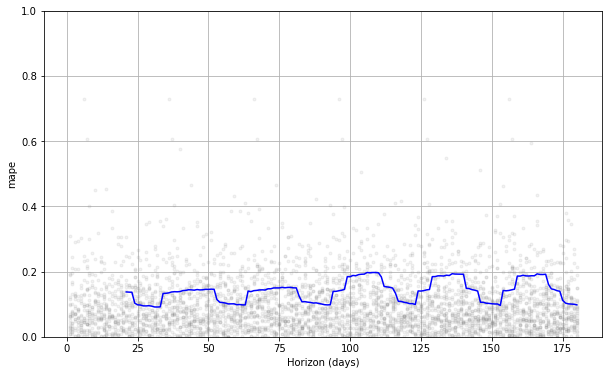

In [15]:
#Define Prophet model
model = Prophet()
initial_df = prelockdown.loc[prelockdown['ds'] < '2019-01-01']
#Fit the model
model.fit(prelockdown)



initial = len(prelockdown.loc[prelockdown.ds < '2019-01-01'])
df_cv = cross_validation(model,initial=f'730 days', horizon='180 days',period='30 days', parallel='processes')
df_p = performance_metrics(df_cv)

mapefig = plot_cross_validation_metric(df_cv, metric='mape')
ax = mapefig.gca()
ax.set_ylim([0,1])

### Your Turn!

Try using the code snippets below and the examples given earlier to create your own models, tweaking the variables and adding code according to the comments.

#### Exercise 1

Recreate the initial prophet model from LINK but tweaking the periods used on the future forecast.

The data has been preprocessed for you.

In [ ]:
## Create a basic Prophet model and change the periods

## DON'T CHANGE THE CODE BELOW

#Prepare expected column names
processed_data = day.reset_index()
processed_data.columns = ['ds','y']

#Create a prelockdown dataset for use in the initial model
prelockdown = processed_data.loc[(processed_data.ds < '2020-03-16') & (processed_data.ds >= '2015-01-01')]

lockdown = processed_data.loc[processed_data.ds >= '2020-03-16'].drop(['y'],axis=1)

#START ADDING CODE BELOW EACH COMMENT

#Define Prophet model


#Fit the model

#future is just a dataset that can be used to predict on.  It can be out of sample or represent a test dataset.


#use the model to make a forecast

#Plot the model below

#### Exercise 2

Recreate the validation model in LINK.  Change the Train/Test split dates to use more/less of each.  Make sure the dates follow on from one another.

In [ ]:

#START ADDING CODE BELOW EACH COMMENT
#Evaluation of model.  Use the code above to set different training and test dates (making sure they align)


#Define Prophet model


#Fit the model


#use the model to make a forecast

#calculate MAE between expected and predicted values


## DON'T EDIT THE CODE BELOW
plotdf = pd.DataFrame({'Date': test_y['ds'], 'y_true':y_true,'y_pred':y_pred})
plotdf.set_index(['Date'],inplace=True)

plotdf['y_true_r_mean'] = plotdf['y_true'].rolling(7).mean()
plotdf['y_pred_r_mean'] = plotdf['y_pred'].rolling(7).mean()

plotdf.drop(['y_pred','y_true'],axis=1, inplace=True)


fig = plotdf.plot(figsize=(15,10))
print('MAE: %.3f' % mae)

#### Exercise 3

Try using the below and from the regressors sections to add/remove regressors from the model and explore how this changes the error and output chart.  Copy the line of code responsible for selecting a subset of regressors and try editing it to see what the outcome is.

Make sure you complete the code before trying to run it.

In [ ]:
# DON'T CHANGE THE CODE BELOW

#Run a pipeline to clean and process the resampled data, adding regressors and dropping null values
# Functions can be found in source.py, most are just combining various datasets and joining them onto the footfall.
warnings.filterwarnings('ignore')
processed_data_with_regressors = (day
                          .pipe(start_pipeline)
                          .pipe(create_date_predictors)
                          .pipe(create_holiday_predictors,bankhols,schoolterms)
                          .pipe(create_weather_predictors, new_weather, previous_weather)
                          .pipe(drop_na))

#ENTER CODE BELOW THIS COMMENT
# Selecting the regressors we're interested in (ENTER YOUR OWN SELECTION OF REGRESSORS)




## DON'T EDIT CODE BELOW

regressors = processed_data_with_regressors.columns
regressors = regressors.tolist()
regressors.remove('mean_hourly_footfall')

#Prepare expected column names
processed_data_with_regressors = processed_data_with_regressors.reset_index()
processed_data_with_regressors = processed_data_with_regressors.rename(columns={'key_0':'ds','mean_hourly_footfall':'y'})

prelockdown = processed_data_with_regressors.loc[
    (processed_data_with_regressors.ds < '2020-03-16') & (processed_data_with_regressors.ds >= '2015-01-01')]

lockdown = processed_data_with_regressors.loc[processed_data_with_regressors.ds >= '2020-03-16'].drop(['y'],axis=1)

#Make sure cols are scaled (Only mean_temp, wind_speed and rain need scaling if included)
cols_to_scale = ['mean_temp', 'wind_speed', 'rain']

#Evaluation of model
train = prelockdown.loc[prelockdown.ds <'2019-01-01']
test = prelockdown.loc[prelockdown.ds >='2019-01-01'].drop(['y'],axis=1)

train.loc[:,cols_to_scale] = min_max_scaler.fit_transform(train.loc[:,cols_to_scale])




#Define Prophet model and add each regressor separately
model = Prophet()
for r in regressors:
	model.add_regressor(r)
#Fit the model
model.fit(train)



test.loc[:,cols_to_scale] = min_max_scaler.transform(test.loc[:,cols_to_scale])
#use the model to make a forecast
forecast = model.predict(test)

#calculate MAE between expected and predicted values
future_y = prelockdown.loc[prelockdown.ds >='2019-01-01']
y_true = future_y['y'].values
y_pred = forecast['yhat'].values
mae = mean_absolute_error(y_true,y_pred)

plotdf = pd.DataFrame({'Date': future_y['ds'], 'y_true':y_true,'y_pred':y_pred})
plotdf.set_index(['Date'],inplace=True)




plotdf['y_true_r_mean'] = plotdf['y_true'].rolling(7).mean()
plotdf['y_pred_r_mean'] = plotdf['y_pred'].rolling(7).mean()

plotdf.drop(['y_pred','y_true'],axis=1, inplace=True)


fig = plotdf.plot(figsize=(15,10))
print('Mean Average Error: %.3f' % mae)

### Stretch goal!

See if you can fill in the gaps below to adjust the model to make a prediction on the data after lockdown started (from 16th March 2020).  How good is the model at making a prediction 'out of sample' compared to the previous one?

Note lockdown predictors have been created for you, they are:



In [ ]:
#Run a pipeline to clean and process the resampled data, adding regressors and dropping null values
# Functions can be found in source.py, most are just combining various datasets and joining them onto the footfall.
processed_data_with_lockdown_regressors = (day
                          .pipe(start_pipeline)
                          .pipe(create_lockdown_predictors)
                          .pipe(create_date_predictors)
                          .pipe(create_holiday_predictors,bankhols,schoolterms)
                          .pipe(create_weather_predictors, new_weather, previous_weather)
                          .pipe(drop_na))

# Selecting the regressors we're interested in (See above)
processed_data_with_regressors = processed_data_with_regressors.loc[:,[
    'mean_hourly_footfall',
    'wday_Saturday',
    'wday_Sunday',
    'mean_temp',
    'wind_speed',
    'rain',
    'bank_hols',
    'schoolholidays']]


regressors = processed_data_with_regressors.columns
regressors = regressors.tolist()
regressors.remove('mean_hourly_footfall')

#Prepare expected column names
processed_data_with_regressors = processed_data_with_regressors.reset_index()
processed_data_with_regressors = processed_data_with_regressors.rename(columns={'key_0':'ds','mean_hourly_footfall':'y'})

prelockdown = processed_data_with_regressors.loc[
    (processed_data_with_regressors.ds < '2020-03-16') & (processed_data_with_regressors.ds >= '2015-01-01')]

lockdown = processed_data_with_regressors.loc[processed_data_with_regressors.ds >= '2020-03-16'].drop(['y'],axis=1)

cols_to_scale = ['mean_temp', 'wind_speed', 'rain']

#Evaluation of model
train = prelockdown.loc[prelockdown.ds <'2019-01-01']
test = prelockdown.loc[prelockdown.ds >='2019-01-01'].drop(['y'],axis=1)

train.loc[:,cols_to_scale] = min_max_scaler.fit_transform(train.loc[:,cols_to_scale])

#Define Prophet model
model = Prophet()
for r in regressors:
	model.add_regressor(r)
#Fit the model
model.fit(train)

test.loc[:,cols_to_scale] = min_max_scaler.transform(test.loc[:,cols_to_scale])
#use the model to make a forecast
forecast = model.predict(test)

#calculate MAE between expected and predicted values
future_y = prelockdown.loc[prelockdown.ds >='2019-01-01']
y_true = future_y['y'].values
y_pred = forecast['yhat'].values
mae = mean_absolute_error(y_true,y_pred)

plotdf = pd.DataFrame({'Date': future_y['ds'], 'y_true':y_true,'y_pred':y_pred})
plotdf.set_index(['Date'],inplace=True)

plotdf['y_true_r_mean'] = plotdf['y_true'].rolling(7).mean()
plotdf['y_pred_r_mean'] = plotdf['y_pred'].rolling(7).mean()

plotdf.drop(['y_pred','y_true'],axis=1, inplace=True)


fig = plotdf.plot(figsize=(15,10))
print('Mean Average Error: %.3f' % mae)